In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import Input, Model, layers, losses, optimizers

from matplotlib import pyplot as plt

2022-12-01 14:36:45.886400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Differential Privacy**

The goal of differential privacy is to minimize the effect, a single training sample can have of the output of a (randomized) algorithm. Therefore, perform the following tasks:
1) Load the boston housing dataset, one-hot encode the categorical features and normalize (use StandardScaler) the continuous features.

2) Split the data into train/test (80% / 20%) sets (give a seed for reproducibility, i.e. random_state=42).

3) Train a LinearRegression model (set fit_intercept=False) on the training set and compute r2_score and mean_squared_error on the test set.

4) Find the training sample with the largest prediction error. Create a mask to exclude that **sample** from the training set.

5) Fit the same LinearRegression model to the training set excluding the found **sample**. Measure the deviation of the two regression models (e.g. np.linalg.norm(w-w'), the weights w can be found in LinearRegression.coef_)

6) Add noise of varying scales to the training set, create a second training set by excluding the **sample** and train linear regression models on each. How does the utility (r2_score, mse) behave with increasing noise level? What happens to the difference between the fitted models' weights? What about the prediction error on the **sample**? Plot the r2_score, mse, prediction error on **sample** and weight difference over the noise scale.




In [2]:
# load dataset
boston_dataset = datasets.load_boston()
X = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
Y = pd.DataFrame(boston_dataset.target, columns=['price'])

# normalize continuous features
cont_features = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
feature_scaler = StandardScaler()
X_pp = X.copy()
X_pp[cont_features] = feature_scaler.fit_transform(X[cont_features])
X_pp.head()

# normalize targets
Y_pp = Y.copy()
target_scaler = StandardScaler()
Y_pp[['price']] = target_scaler.fit_transform(Y[['price']])

# one-hot-encode the 'RAD' feature
X_pp[['CHAS', 'RAD']] = X_pp[['CHAS', 'RAD']].astype('int32')
X_pp = pd.get_dummies(X_pp, columns=['RAD'])
X_pp.head()

# split data and target DataFrames into data train, data test, target train and target test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_pp.to_numpy(), Y_pp.to_numpy(), test_size=0.20, random_state=42)

/home/david/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing datas

In [21]:
# train regression model and find sample with largest prediction error
LR = LinearRegression(fit_intercept=False)
LR.fit(X_train, Y_train)

pred = LR.predict(X_test)

print('r2 score:', r2_score(Y_test, pred))
print('mean squared error:', mean_squared_error(Y_test, pred))

index_max_err = np.argmax([(LR.predict(X_train) - Y_train) ** 2])
print('index of sample with the largest error:', index_max_err)

# create neighboring dataset, i.e. training set without the sample with largest prediction error
mask = np.ones(X_train.shape[0], dtype=bool)
mask[index_max_err] = False

# train on that dataset the same model, measure the difference between both models' coefficients
LR2 = LinearRegression(fit_intercept = False)
LR2.fit(X_train[mask], Y_train[mask])
pred2 = LR2.predict(X_test)


print('r2 score:', r2_score(Y_test, pred2))
print('mean squared error:', mean_squared_error(Y_test, pred2))

print('coef difference', np.linalg.norm(LR.coef_-LR2.coef_))

r2 score: 0.6615687658684821
mean squared error: 0.29398925875149384
index of sample with the largest error: 126
r2 score: 0.648810290104261
mean squared error: 0.30507232217602603
coef difference 0.12460854606920624


In [49]:
# train on varying noise scales, you should repeat the computation for each sigma several times and average
sigmas = np.logspace(-3,2, 100) # noise scales

n = 30

r2 = []
mse = []
pred_err = []
w_diff = []

for sigma in sigmas :
    X_noise = X_train + sigma * np.random.randn(*X_train.shape)
    
    r2_ = []
    mse_ = []
    pred_err_ = []
    w_diff_ = []
    
    for i in range(n) :
        LR.fit(X_noise, Y_train)
        LR2.fit(X_noise[mask], Y_train[mask])
        
        pred1 = LR.predict(X_test)
        pred2 = LR.predict(X_test)
        
        r2_.append(r2_score(Y_test, pred1))
        mse_.append(mean_squared_error(Y_test, pred1))
        pred_err_.append(np.absolute((LR.predict(X_noise) - Y_train)[index_max_err]))
        w_diff_.append(np.linalg.norm(LR.coef_-LR2.coef_))
        
    r2.append(sum(r2_)/n)
    mse.append(sum(mse_)/n)
    pred_err.append(sum(pred_err_)/n)
    w_diff.append(sum(w_diff_)/n)

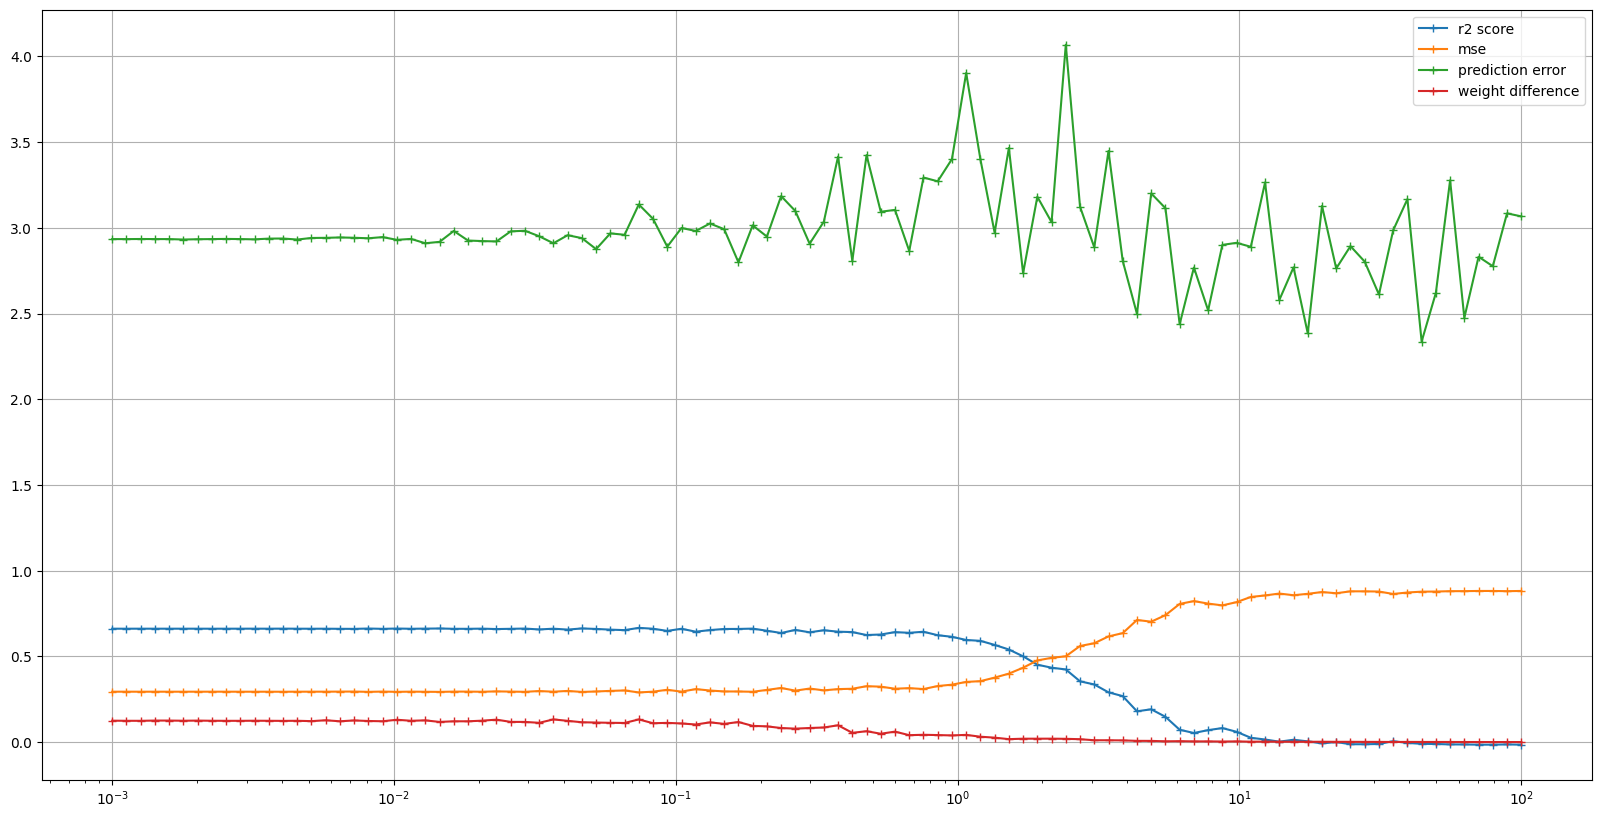

In [50]:
# plot results
plt.figure(figsize=(20, 10))
plt.xscale('log')
plt.grid()
plt.plot(sigmas, r2, label='r2 score', marker='+')
plt.plot(sigmas, mse, label='mse', marker='+')
plt.plot(sigmas, pred_err, label='prediction error', marker='+')
plt.plot(sigmas, w_diff, label='weight difference', marker='+')

plt.legend()
plt.show()

**Autoencoder**

An autoencoder is a model that maps samples into a so-called latent space and then back to the original space. It consists of an encoder model X->Z and a decoder model Z->X. 
It is used for dimensionality reduction, representation learning and as generative model. The training objective of an autoencoder is usually a combination of reconstruction error and some regularization (on its weights and/or the latent representation).

1) Load the mnist dataset, split into 10k training samples and 1000 test samples. Take 1000 training samples for evaluation.

2) Build a linear autoencoder (encoder/decoder are linear models each). Train your autoencoder with 2D latent space Z. 

3) Visualize the results as follows: For 1000 training and 1000 test samples

    a) Create a scatterplot of the latent embeddings
    
    b) Plot the reconstructions of 100 samples in a 10x10 grid
    
    c) Plot the corresponding original samples below
    
3) Build a non-linear autoencoder. The encoder has 2 conv layers (32/64 filters of size (3,3), strides 2), followed by a dense layer that maps to 2-dimensional latent variables. The decoder consists of a dense layer, followed by 2 conv-transpose layers (64/32, ... matching the encoder). Train the non-linear autoencoder and visualize the results as above.

4) Create synthetic samples by randomly sampling 100 points in latent space and decoding them using the linear and non-linear decoders.


In [51]:
# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

X = x_train.astype('float32').reshape((-1, 28,28,1))/255.
Xtrain, Xtest_, Ytrain, Ytest_ = train_test_split(X, y_train, train_size=10000)
Xtest, Xtest_, Ytest, Ytest_ = train_test_split(Xtest_, Ytest_, train_size=1000)

Xtrain_, _, Ytrain_, _ = train_test_split(Xtrain, Ytrain, train_size=1000)

In [52]:
# helper function to plot several samples in one image
def make_grid(X, grid_size=[10,10]):
    sh = [X.shape[1], X.shape[2]]
    G = np.zeros((sh[0]*grid_size[0], sh[1]*grid_size[1]))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            G[i*sh[0]:(i+1)*sh[0], j*sh[1]:(j+1)*sh[1]] = X[i*grid_size[1]+j].reshape(sh)
    return G

In [53]:
# define autoencoder model
class AutoEncoder(Model):
    
    def __init__(self, encoder, decoder, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, X, training=None):
        z = self.encoder(X)
        x = self.decoder(z)
        return x    

In [56]:
# linear models    

lin_enc = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(2)
        ])
lin_dec = tf.keras.Sequential([
            layers.Dense(28*28),
            layers.Reshape((28,28))
        ])

lin_ae = AutoEncoder(lin_enc, lin_dec)

In [58]:
# train linear autoencoder
opt = optimizers.Adam(learning_rate=0.01)
loss = losses.MeanSquaredError()
lin_ae.compile(optimizer=opt, loss=loss, metrics=['mae'])

lin_ae.fit(Xtrain, Xtrain, epochs=100, shuffle=True, validation_split=0.1)

Epoch 1/100
282/282 [==============================] - 1s 3ms/step - loss: 0.0610 - mae: 0.1384 - val_loss: 0.0574 - val_mae: 0.1331
Epoch 2/100
282/282 [==============================] - 1s 2ms/step - loss: 0.0573 - mae: 0.1339 - val_loss: 0.0564 - val_mae: 0.1325
Epoch 3/100
282/282 [==============================] - 1s 2ms/step - loss: 0.0570 - mae: 0.1331 - val_loss: 0.0564 - val_mae: 0.1321
Epoch 4/100
282/282 [==============================] - 1s 2ms/step - loss: 0.0570 - mae: 0.1332 - val_loss: 0.0566 - val_mae: 0.1335
Epoch 5/100
282/282 [==============================] - 1s 2ms/step - loss: 0.0570 - mae: 0.1333 - val_loss: 0.0567 - val_mae: 0.1312
Epoch 6/100
282/282 [==============================] - 1s 2ms/step - loss: 0.0570 - mae: 0.1331 - val_loss: 0.0565 - val_mae: 0.1313
Epoch 7/100
282/282 [==============================] - 1s 2ms/step - loss: 0.0571 - mae: 0.1332 - val_loss: 0.0573 - val_mae: 0.1360
Epoch 8/100
282/282 [==============================] - 1s 2ms/step - 

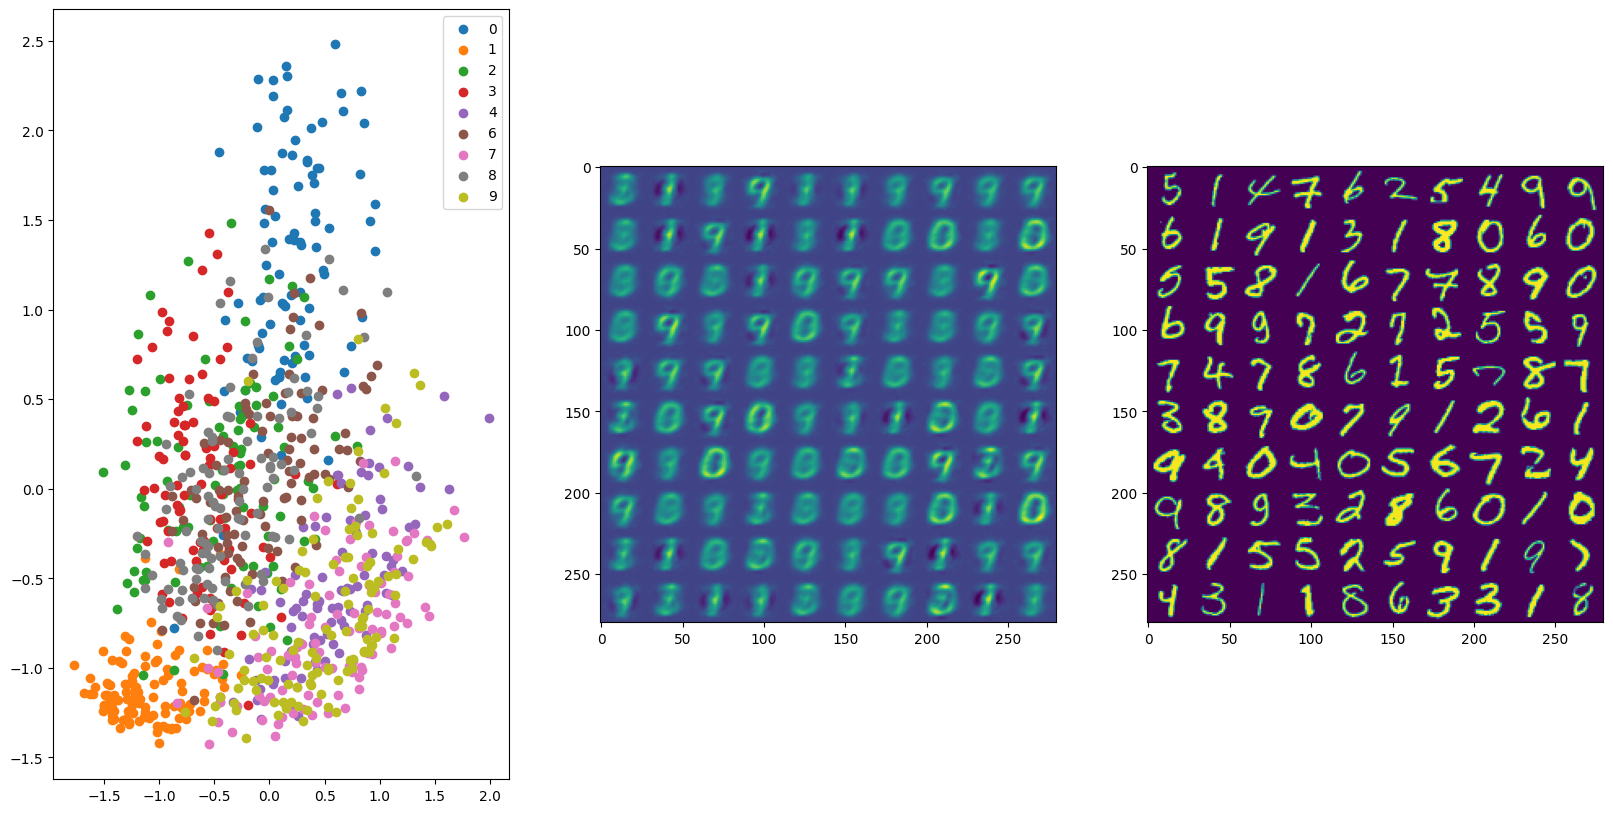

In [69]:
# visualize latent space, reconstructions and original samples for train and test data

def visu (lin_ae) :
    encoded_imgs = lin_ae.encoder(Xtest).numpy()
    decoded_imgs = lin_ae.decoder(encoded_imgs).numpy()


    decoded_grid = make_grid(decoded_imgs)
    original_grid = make_grid(Xtest)

    fig, axes = plt.subplots(ncols=3, figsize=(20,10))
    axes[1].imshow(decoded_grid)
    axes[2].imshow(original_grid)

    for y in [0,1,2,3,4,6,7,8,9] :
        mask =  (Ytest == y)
        axes[0].scatter(encoded_imgs[mask, 0], encoded_imgs[mask,1], label=y)
    axes[0].legend()

visu(lin_ae)

In [12]:
# nonlinear models


In [13]:
# train non-linear autoencoder

In [14]:
# Visualization as before for non-linear model


In [15]:
# Try out linear decoder as generative model


In [16]:
# Non-linear decoder as generative model
